# Проект 4. Итоговый вызов. Компьютер говорит «Нет»
### Скороходов Андрей (DST10)

### Импорт библиотек

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

### Загрузка данных

In [3]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [4]:
print('Размерность тренировочной выборки: ', train.shape)
print('Размерность тестовой выборки: ', test.shape)

Размерность тренировочной выборки:  (73799, 19)
Размерность тестовой выборки:  (36349, 18)


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

### Предварительный анализ данных

### 0. Основные моменты

0    64427
1     9372
Name: default, dtype: int64


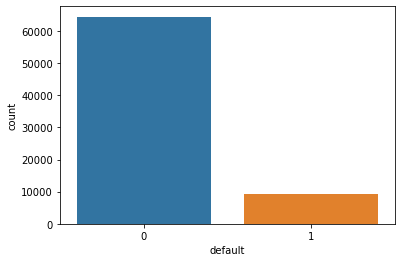

In [5]:
sns.countplot(train['default'])
print(train['default'].value_counts())

Вывод из примера: "Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше"

In [6]:
# Объединение датасетов для более точного разбора статистики
dataset= train.append(test, sort=False).reset_index(drop=True)
print('Размерность датасета: ', dataset.shape)

Размерность датасета:  (110148, 19)


Проверка наличия пропусков в датасете

In [7]:
dataset.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

Пропуски есть только в поле "education", разберемся ниже

In [8]:
dataset.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


Ну что сказать тут... Кому-то одобрили кредит в миллион, но это пока не точно.

### 1. Признак "education"

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64


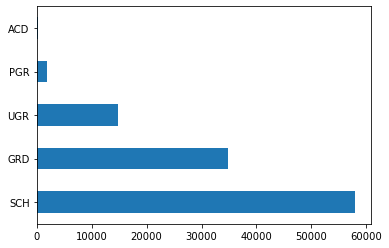

In [9]:
dataset['education'].value_counts().plot.barh()
print(dataset['education'].value_counts())

Вывод: очень мало клиентов с образованием ACD и без образования.
В случае плохих результатов, попробуем вернуться к этим признакам позже, а пока заполним пропуски образованием SCH (без вот этих вот модных collections, чтобы блокнот отличался от исходного хоть чуть-чуть)

In [10]:
print('Количество NAN в обучающей выборе: ', train.isnull().sum().sum())
print('Количество NAN в тестовой выборке: ', test.isnull().sum().sum())

Количество NAN в обучающей выборе:  307
Количество NAN в тестовой выборке:  171


Нет, ну все таки образование должно же хоть как-то влиять на тех, кто берет кредиты!
На всякий случай.. Возьмем исходный датасет и заменим там пропущенное образование на "NA"

In [11]:
dataset['education'].fillna('NA', inplace=True)

dataset.groupby('education').mean().sort_values(by = 'default')


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
education,,,,,,,,,,,,,
ACD,54937.233677,40.323024,0.178694,0.457045,-2.069584,1.786942,64.604811,1.646048,2.611684,85949.405498,1.532646,3.164948,0.041237
PGR,54567.982306,38.567292,0.194102,0.305094,-1.975544,2.111528,61.233244,1.584987,2.512601,79753.214477,1.443968,3.075067,0.064439
GRD,56562.968793,38.066584,0.227048,0.251668,-1.920431,2.158335,58.506673,1.569087,2.489416,54315.008916,1.567016,2.942792,0.090092
NA,50891.301255,41.437238,0.106695,0.142259,-1.945634,1.761506,60.418410,1.619247,2.562762,46240.956067,1.635983,2.905858,0.114007
UGR,57608.856048,34.860523,0.350963,0.165921,-1.855721,1.787225,57.914293,1.600488,2.534242,39009.904868,1.773935,2.686873,0.131520
SCH,53589.214352,41.073020,0.285493,0.108004,-1.903968,1.968137,55.189317,1.570916,2.492103,32033.254681,1.830511,2.666230,0.150592


Если я правильно понимаю, то здесь представлены все градации образования: SCH - школа, UGR - студенты, GRD - аспиранты, PGR - ученые со степенями, ACD - предположу, что академики. И чем выше степень образования, тем меньше default. Но вот эти люди без образования все портят.. затесались между студентами и аспирантами.. И еще у них очень маленькое количество отказанных прошлых заявок, хотя кредит они берут далеко не первый раз. Вот надеюсь не зря я это все начал.

In [12]:
train['education'].fillna('UGR', inplace=True)
test['education'].fillna('UGR', inplace=True)
print('Количество NAN в обучающей выборе: ', train.isnull().sum().sum())
print('Количество NAN в тестовой выборке: ', test.isnull().sum().sum())

Количество NAN в обучающей выборе:  0
Количество NAN в тестовой выборке:  0


Не знаю я зачем это начал. Но чтобы хоть не зря казалось, то заполню все же пропуски в образовании не школьниками, а студентами. Киллер фича, о да!
Кстати так и не понял, кто такие ACD, судя по возрасту явно не академики, но платят кредиты исправно.
Наверное, это яркий пример, на что не стоит тратить время..

### 2. Признак "app_date"

Конвертируем общий датасет.

In [13]:
dataset.app_date = pd.to_datetime(dataset.app_date)
dataset.sort_values('app_date')

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
11038,42,2014-01-01,UGR,F,47,Y,N,0,0,-2.211580,1,60,2,3,35000,1,4,Y,0.0
25920,14,2014-01-01,SCH,F,36,N,N,0,0,-2.164185,0,70,1,1,90000,1,4,Y,0.0
72759,56,2014-01-01,UGR,M,25,N,N,0,1,-1.629831,5,80,2,3,50000,1,3,N,0.0
108665,35,2014-01-01,GRD,M,35,N,N,0,1,-2.211979,1,70,1,2,50000,1,3,Y,NaN
31672,20,2014-01-01,SCH,M,47,N,N,4,0,-2.047099,3,50,1,2,30000,1,2,N,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64006,109644,2014-04-30,UGR,F,29,N,N,0,0,-1.937661,0,50,2,3,15000,1,2,N,0.0
50840,109937,2014-04-30,SCH,M,37,Y,N,0,0,-1.372804,1,50,1,1,30000,3,1,N,0.0
81386,110116,2014-04-30,SCH,F,46,N,N,0,0,-2.049589,3,50,2,3,18000,3,2,N,NaN
1170,110060,2014-04-30,GRD,M,40,N,N,0,1,-2.211677,4,50,2,3,115000,1,3,N,0.0


Все данные за 2014 год, причем за несколько месяцев всего, но ничего подозрительного. Конвертируем наши выборки.
Там в примере кстати была небольшая ошибка, если это только не специально: test.app_date = pd.to_datetime(train.app_date)

In [14]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

В примере вытаскивались дополнительные признаки, на всякий случай оставлю, плюс раз уж начали, добавлю признак  дня недели.
На всякий случай попробуем найти зависимости

In [15]:
current_date = pd.to_datetime('28JUL2020')
train['days_passed'] = (current_date - train['app_date']).dt.days.astype('int')

Особого смысла выделять выходные нет, оставляем так. Месяцы не стал выделять, т.к. они сильно скоррелированы с днями

In [16]:
test['days_passed'] = (current_date - test['app_date']).dt.days.astype('int')

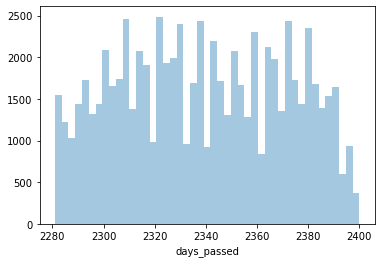

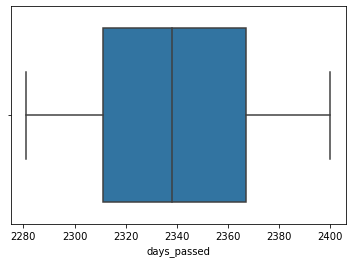

In [17]:
sns.distplot(train['days_passed'], kde = False, rug=False)
plt.show()

sns.boxplot(train['days_passed'])
plt.show()



В выходные оказывается берут меньше кредитов) День недели будем брать как категорию, количество дней логарифмируем.

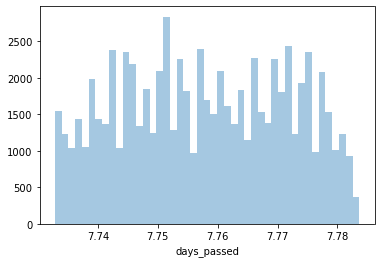

In [18]:
train['days_passed'] = np.log(train['days_passed'] + 1)
test['days_passed'] = np.log(test['days_passed'] + 1)

sns.distplot(train['days_passed'], kde = False, rug=False)
plt.show()

### 3. Признак 'decline_app_cnt'

Посмотрим распределение и выбросы

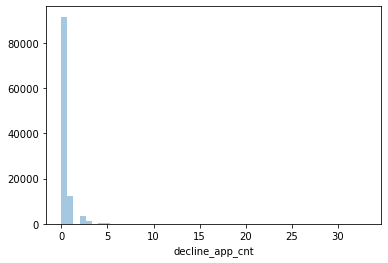

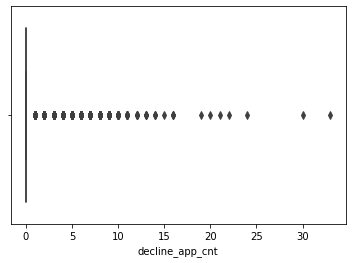

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64


In [19]:
plt.figure()
sns.distplot(dataset['decline_app_cnt'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['decline_app_cnt'])
plt.show()

print(dataset['decline_app_cnt'].value_counts())

Посмотрим, как распределяются дефолты в зависимости от этого параметра

In [20]:
train.groupby('decline_app_cnt').mean().sort_values(by = 'default')

,client_id,age,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,days_passed
decline_app_cnt,,,,,,,,,,,,,
33,108743.000000,42.000000,0.000000,-0.988195,2.000000,50.000000,2.000000,3.000000,20000.000000,4.000000,1.000000,0.000000,7.733246
16,23566.000000,32.500000,0.000000,-1.719010,5.000000,55.000000,1.500000,2.500000,57500.000000,1.000000,3.000000,0.000000,7.771251
13,43168.000000,33.333333,0.000000,-1.210857,6.000000,46.666667,2.000000,3.000000,41666.666667,3.333333,2.000000,0.000000,7.762942
12,35456.500000,24.500000,0.000000,-1.438279,7.000000,55.000000,2.000000,2.500000,25500.000000,3.000000,1.500000,0.000000,7.766325
24,87562.000000,48.000000,0.000000,-0.616087,3.000000,40.000000,2.000000,3.000000,320000.000000,1.000000,3.000000,0.000000,7.744570
0,55410.435783,39.875600,0.170647,-1.950159,1.854935,56.959682,1.573104,2.490737,41662.799441,1.699644,2.799229,0.109534,7.757680
1,54609.318090,37.100631,0.138621,-1.733486,2.480291,55.846136,1.583304,2.518280,38905.923068,1.848994,2.636180,0.187805,7.758026
2,52510.938006,35.714344,0.134117,-1.617417,2.829417,55.356564,1.594408,2.540113,37664.629254,1.973258,2.562804,0.243517,7.758919
5,49870.860606,32.957576,0.157576,-1.507171,3.666667,54.606061,1.600000,2.484848,35348.181818,1.921212,2.496970,0.260606,7.760050


Явной зависимости нет, но можно предположить, что количество отказов обычно не превышает 3-4. В выборке совершенно разные полюса по тем, кто много раз получал откат есть и 0 и 1, но т.к. эти случаи единичны, то скорее всего они портят картину. Поэтому заменяем все, что больше 3 на 3.

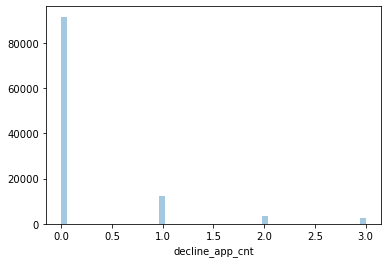

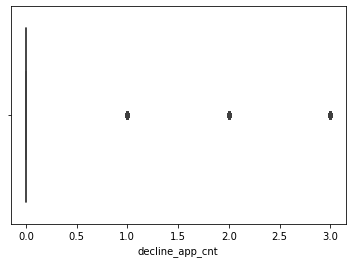

In [21]:
def decline_conv(num):
    if num > 3:
        return 3
    else:
        return num

train['decline_app_cnt'] = train['decline_app_cnt'].apply(decline_conv)
test['decline_app_cnt'] = test['decline_app_cnt'].apply(decline_conv)
dataset['decline_app_cnt'] = dataset['decline_app_cnt'].apply(decline_conv)

sns.distplot(dataset['decline_app_cnt'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['decline_app_cnt'])
plt.show()




Логорифмировать не будем, оставим как категорию

### 4. Признак 'age'

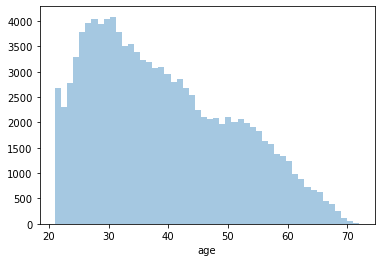

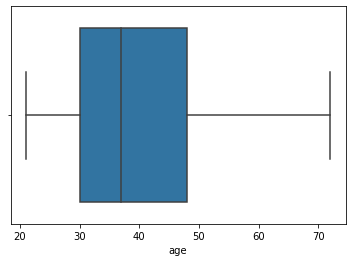

In [22]:
sns.distplot(dataset['age'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['age'])
plt.show()

Тут все нормально, берем логарифм

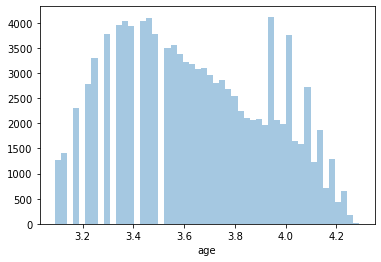

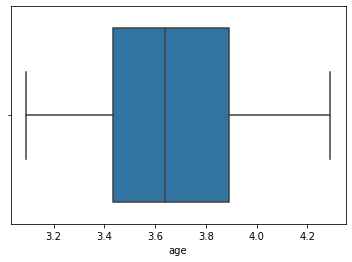

In [23]:
dataset['age'] = np.log(dataset['age'] + 1)
train['age'] = np.log(train['age'] + 1)
test['age'] = np.log(test['age'] + 1)

sns.distplot(dataset['age'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['age'])
plt.show()

### 5. Признак 'score_bki'

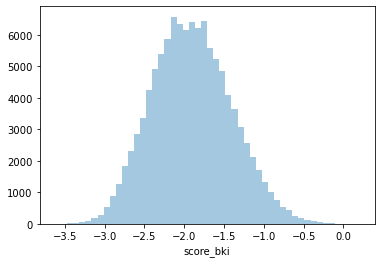

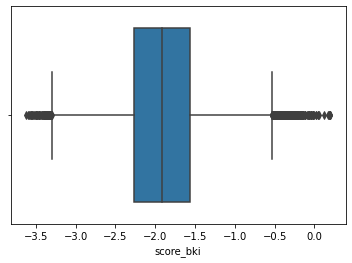

In [24]:
sns.distplot(dataset['score_bki'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['score_bki'])
plt.show()

Распределение нормальное, но есть выбросы. Т.к. это похоже основной параметр, на который ориентируется расчет, посмотрим по внимательнее на границы.

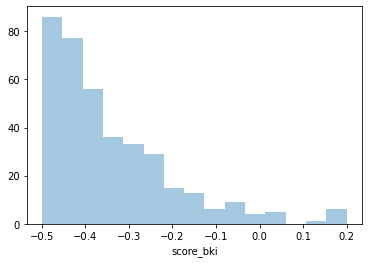

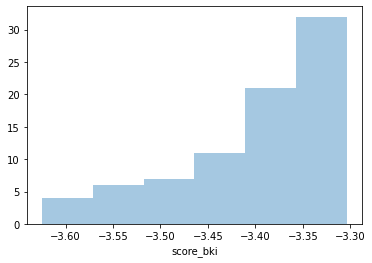

In [25]:
train[train['score_bki'] > -0.5].describe()
sns.distplot(dataset['score_bki'][dataset['score_bki'] > -0.5], kde = False, rug=False)
plt.show()

train[train['score_bki'] < -3.3].describe()
sns.distplot(dataset['score_bki'][dataset['score_bki'] < -3.3], kde = False, rug=False)
plt.show()

In [26]:
train[train['score_bki'] > -0.01].describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,days_passed
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,42878.300000,3.577600,0.300000,0.200000,0.109049,1.100000,54.000000,1.500000,2.600000,36500.000000,1.600000,2.900000,0.500000,7.763056
std,24624.082129,0.234371,0.948683,0.421637,0.087301,1.595131,17.126977,0.527046,0.516398,27500.505046,0.699206,0.875595,0.527046,0.010614
min,11365.000000,3.258097,0.000000,0.000000,-0.006805,0.000000,20.000000,1.000000,2.000000,12000.000000,1.000000,1.000000,0.000000,7.745436
25%,27200.500000,3.409395,0.000000,0.000000,0.029421,0.000000,50.000000,1.000000,2.000000,22500.000000,1.000000,3.000000,0.000000,7.759827
50%,37411.000000,3.522453,0.000000,0.000000,0.112292,0.500000,50.000000,1.500000,3.000000,30000.000000,1.500000,3.000000,0.500000,7.765563
75%,49808.500000,3.743120,0.000000,0.000000,0.194456,1.750000,67.500000,2.000000,3.000000,39000.000000,2.000000,3.000000,1.000000,7.769906
max,84102.000000,3.970292,3.000000,1.000000,0.199773,5.000000,80.000000,2.000000,3.000000,110000.000000,3.000000,4.000000,1.000000,7.776535


Фиг знает, как этот признак выводился, на всякий случай положительный рейтинг уберу в -0.01 (там где дефолт становится 0.5), чтобы переход знака не повлиял на расчет

In [27]:
def score_bki_corr(score):
    if score > -0.01:
        return -0.01
    else:
        return score

train['score_bki'] = train['score_bki'].apply(score_bki_corr)
test['score_bki'] = test['score_bki'].apply(score_bki_corr)

### 6. Признак 'bki_request_cnt'

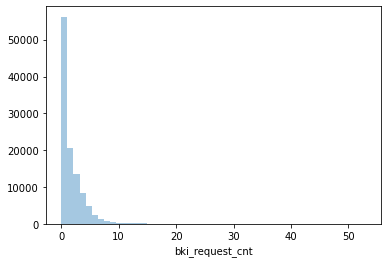

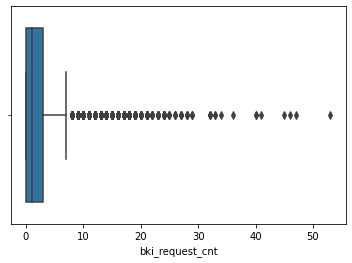

In [28]:
sns.distplot(dataset['bki_request_cnt'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['bki_request_cnt'])
plt.show()

In [29]:
train.groupby('bki_request_cnt').mean().sort_values(by = 'default')

,client_id,age,decline_app_cnt,good_work,score_bki,region_rating,home_address,work_address,income,sna,first_time,default,days_passed
bki_request_cnt,,,,,,,,,,,,,
53,12395.000000,3.663562,0.000000,0.000000,-2.623103,60.000000,1.000000,1.000000,65000.000000,1.000000,3.000000,0.000000,7.775696
36,59365.000000,3.891820,3.000000,0.000000,-1.422165,80.000000,2.000000,3.000000,58290.000000,1.000000,2.000000,0.000000,7.756195
34,73506.000000,3.555348,2.000000,0.000000,-1.680424,50.000000,1.000000,2.000000,40000.000000,2.000000,3.000000,0.000000,7.750184
33,14058.000000,3.871201,3.000000,0.000000,-1.097846,70.000000,2.000000,3.000000,30000.000000,1.000000,1.000000,0.000000,7.775276
26,54508.500000,3.215666,2.000000,0.000000,-1.115958,60.000000,1.500000,3.000000,37500.000000,1.500000,1.500000,0.000000,7.758235
25,25453.500000,4.102336,0.000000,0.000000,-1.472514,65.000000,1.500000,2.500000,60000.000000,1.000000,3.500000,0.000000,7.770642
22,19984.500000,3.747533,0.500000,0.000000,-0.824752,60.000000,1.750000,2.500000,60750.000000,1.750000,3.500000,0.000000,7.772629
0,54055.176100,3.644378,0.190135,0.162118,-1.968216,57.486714,1.577421,2.502554,39889.908312,1.708890,2.766576,0.094990,7.758266
1,56527.390293,3.642465,0.207814,0.164861,-1.947477,56.416065,1.569271,2.487306,38516.768385,1.732436,2.757277,0.118790,7.757196


Какая то зависимость есть от 0 до 4 запросов, сделаем их категориальными, а остальные в случайном порядке размажем по оставшимся категориям и логарифмируем.

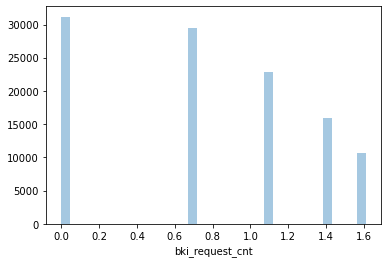

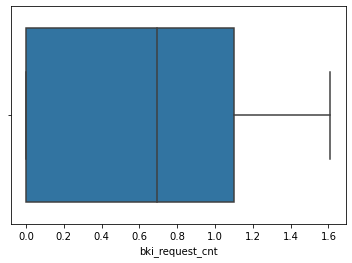

In [30]:
def bki_req_conv(num):
    if num > 4:
        return random.randint(0, 4)
    else:
        return num

train['bki_request_cnt'] = train['bki_request_cnt'].apply(bki_req_conv)
test['bki_request_cnt'] = test['bki_request_cnt'].apply(bki_req_conv)
dataset['bki_request_cnt'] = dataset['bki_request_cnt'].apply(bki_req_conv)

dataset['bki_request_cnt'] = np.log(dataset['bki_request_cnt'] + 1)
train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
test['bki_request_cnt'] = np.log(test['bki_request_cnt'] + 1)

sns.distplot(dataset['bki_request_cnt'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['bki_request_cnt'])
plt.show()

### 7. Признак 'income'

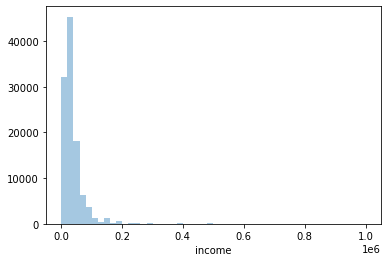

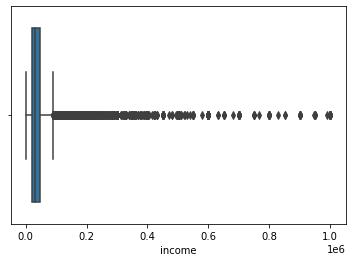

In [31]:
sns.distplot(dataset['income'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['income'])
plt.show()

Логарифмируем. ВЫбросов конечно очень много

In [32]:
dataset['income'] = np.log(dataset['income'] + 1)
train['income'] = np.log(train['income'] + 1)
test['income'] = np.log(test['income'] + 1)

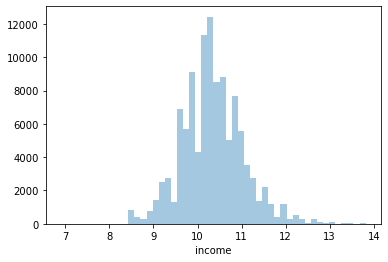

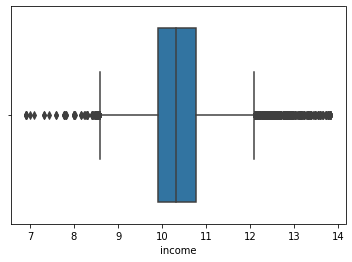

In [33]:
sns.distplot(dataset['income'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['income'])
plt.show()

слишком большие суммы приведем к границам 5% и 95%, чтобы они не портили статистику.

In [34]:
def outliers_remove(data,low=0,high=100):
    if data > high:
        return high
    elif data < low:
        return low
    else:
        return data
    
limit_low = dataset['income'].quantile(q=0.05, interpolation='linear')
limit_high = dataset['income'].quantile(q=0.95, interpolation='linear')

dataset['income'] = dataset['income'].apply(outliers_remove,low = limit_low, high = limit_high)

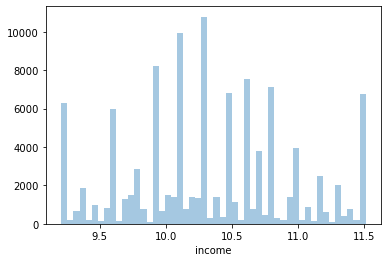

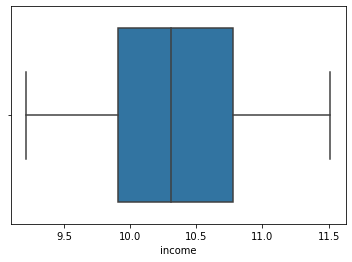

In [35]:
sns.distplot(dataset['income'], kde = False, rug=False)
plt.show()
sns.boxplot(dataset['income'])
plt.show()

Возможно, можно еще укрупнять, приводя суммы к каким то стандартным значениям. Но не уверен, что есть зависимость между "круглой суммой" и процентом возврата.

### 8. Признак 'sna'

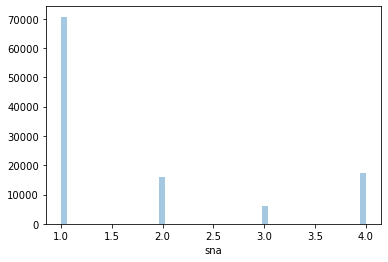

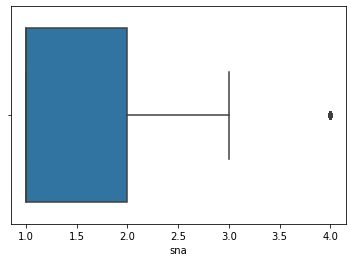

In [36]:
sns.distplot(dataset['sna'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['sna'])
plt.show()

Признак "сна".. от 1 до 4, странно что нет людей без связей с клиентами банка. Или если ты берешь кредит, ты уже считаешься клиентом?

In [37]:
train.groupby('sna').mean().sort_values(by = 'default')

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,first_time,default,days_passed
sna,,,,,,,,,,,,,
1,55361.920763,3.677690,0.215450,0.180313,-1.933130,0.765022,57.498573,1.546648,2.459969,10.401695,3.133782,0.098201,7.757700
2,54166.102673,3.599344,0.296160,0.146245,-1.858618,0.781343,55.810277,1.537361,2.444758,10.329517,2.481272,0.149821,7.758215
3,55125.993209,3.578047,0.339316,0.133641,-1.842975,0.763538,55.377153,1.543051,2.470046,10.250999,2.216347,0.157652,7.757799
4,55119.499106,3.643076,0.319687,0.130649,-1.853830,0.785633,54.915312,1.737595,2.698272,10.169300,1.732318,0.211507,7.757808


Ожидаемо, что чем больше связей, тем надежнее заемщик. Оставляем пока так

### 9. Признак 'first_time'

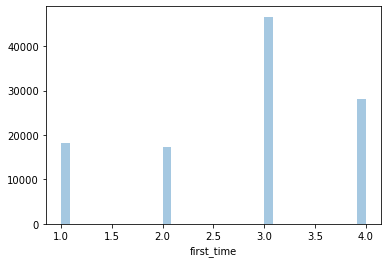

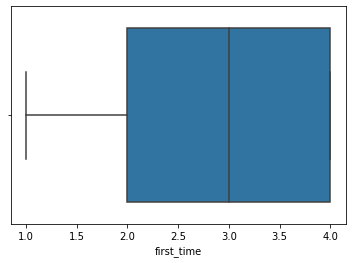

In [38]:
sns.distplot(dataset['first_time'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['first_time'])
plt.show()

In [39]:
train.groupby('first_time').mean().sort_values(by = 'default')

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,default,days_passed
first_time,,,,,,,,,,,,,
4,57142.530821,3.708564,0.180765,0.188344,-1.968830,0.765983,58.957144,1.577734,2.489726,10.474749,1.176015,0.082030,7.756940
3,54257.716717,3.649778,0.244761,0.171141,-1.897265,0.777161,56.112942,1.539786,2.452280,10.360688,1.506863,0.120269,7.758172
2,53696.834630,3.601383,0.316131,0.150588,-1.855495,0.764932,56.658022,1.559042,2.485131,10.315861,1.864799,0.155429,7.758419
1,55679.154098,3.639011,0.310401,0.126563,-1.872256,0.766092,54.938312,1.678895,2.629218,10.139182,3.040608,0.186126,7.757561


Аналогично sna: 4 значения, но вероятность дефолта клиента, берущего кредит в 4 раз сильно меньше остальных. Справедливо

### 10. Признак 'region_rating'

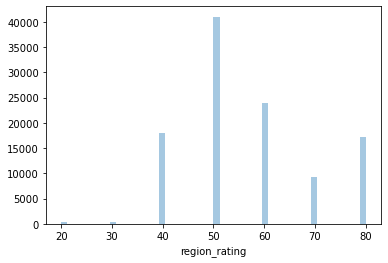

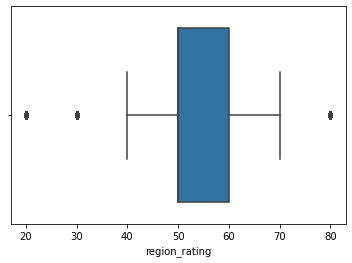

In [40]:
sns.distplot(dataset['region_rating'], kde = False, rug=False)
plt.show()

sns.boxplot(dataset['region_rating'])
plt.show()

In [41]:
train.groupby('region_rating').mean().sort_values(by = 'default')

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,default,days_passed
region_rating,,,,,,,,,,,,,
80,55753.090243,3.614327,0.192345,0.231232,-1.901916,0.720545,1.951434,2.942890,10.786018,1.484175,3.027553,0.073154,7.757556
70,54806.179384,3.609831,0.237619,0.190192,-1.857071,0.774984,1.450073,2.557187,10.700322,1.600903,2.714793,0.092434,7.757952
60,55136.856983,3.651395,0.262271,0.157201,-1.914358,0.784860,1.569705,2.461586,10.279196,1.849580,2.728523,0.128834,7.757802
50,55258.007521,3.669779,0.255641,0.142971,-1.915630,0.773668,1.478400,2.369291,10.206975,1.798895,2.714748,0.136141,7.757733
40,54467.229567,3.687635,0.280868,0.146587,-1.893145,0.787678,1.505363,2.371331,10.162392,1.726698,2.715806,0.169702,7.758078
30,53487.776667,3.710223,0.353333,0.190000,-1.912680,0.791042,1.523333,2.336667,10.042726,1.916667,2.516667,0.190000,7.758519
20,56486.252427,3.718509,0.378641,0.271845,-1.956237,0.865292,2.019417,3.000000,10.093782,1.878641,2.616505,0.213592,7.757180


Такое чуство, что рейтинг региона составляли на основании показателя дефолта, уж больно прямая зависимость. Распределение нормальное, оставляем

### 11. Группировка признаков

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [42]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address','sna', 'first_time', 'bki_request_cnt','decline_app_cnt']
num_cols = ['days_passed', 'age', 'score_bki', 'region_rating', 'income']

### 12. Матрица корреляции

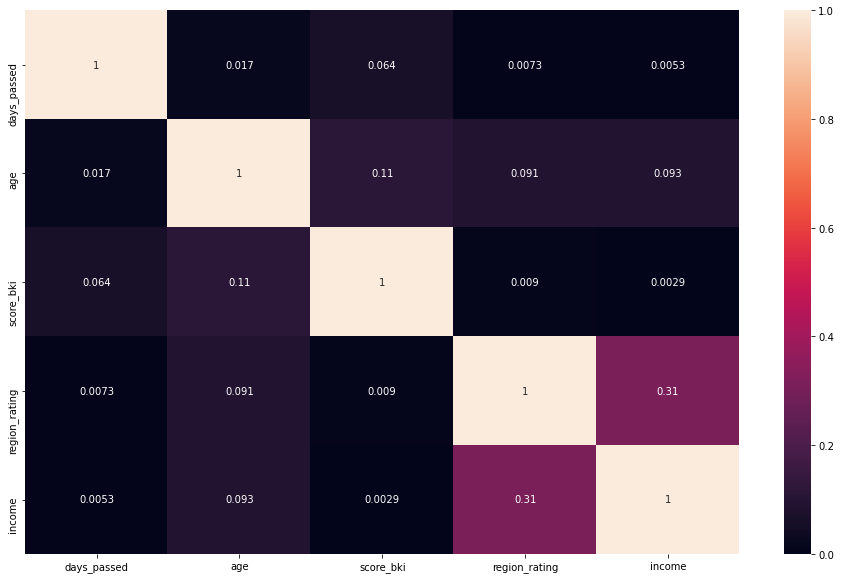

In [43]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Не хотелось бы повторяться, но "Высокой корреляции между признаками не наблюдается", максимум 0.31

### 13. Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

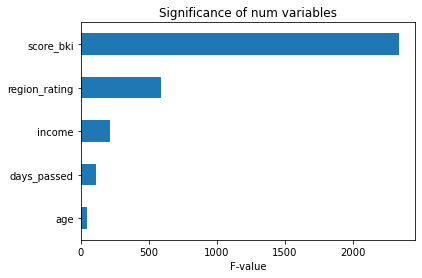

In [44]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

Такое чувство, что банк выдает кредиты в основном на базе уже добытой ранее информации: оценки БКИ и кол-ва отказов (но отказы мы перевели в категории).
Странно, что возраст в этом распределении на последнем месте, ведь с возрастом люди должны становиться мудрее..

## Работа с бинарными и категориальными переменными

### 14. Преобразование бинарных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [45]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании    
display(train.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed
0,25905,2014-02-01,SCH,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,7.770645
1,63161,2014-03-12,SCH,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,7.754053
2,25887,2014-02-01,SCH,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,7.770645
3,16222,2014-01-23,SCH,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,7.774436
4,101655,2014-04-18,GRD,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,7.738052


### 15. Значимость бинарных признаков

Text(0.5, 1.0, 'Significance of bin variables')

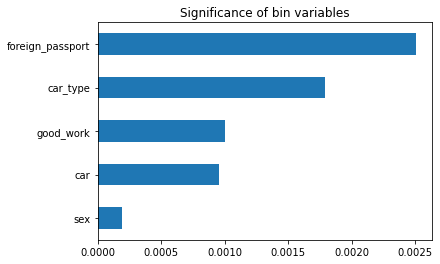

In [46]:
imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Странно, что наличие загранпаспорта так много значит. Но в целом все достаточно толерантно)

### 16. Преобразование категориальных переменных

Преобразуем категориальные переменные при помощи OneHotEncoder

In [47]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73799, 28)
(36349, 28)


Разбиваем данные при помощи get_dummies

In [48]:
education_dummy = pd.get_dummies(train['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


In [49]:
#weekday_dummy = pd.get_dummies(train['weekday'])
#weekday_dummy.head()

### 17. Значимость категориальных переменных

Text(0.5, 1.0, 'Significance of cat variables')

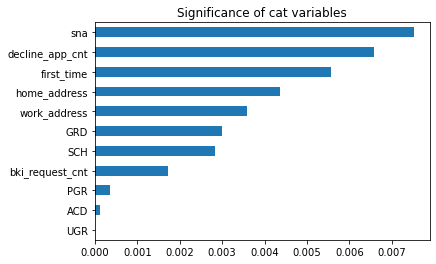

In [50]:
# Значимость категориальных признаков
new_cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'bki_request_cnt','decline_app_cnt']

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Признак UGR вообще не участвует во всеобщем веселье, зато SNA, first_time и счетчик отказов опять на первых местах, т.е. опять в первую очередь важна кредитная история.
Удивительно, что образование стоит ниже места работы и жительства, наверное это связано с кредитоспособностью - не обязательно получать диплом, чтобы жить в престижном месте и работать на хорошей работе.
Дни недели вообще значения не имеют. Нафик.

## Подготовка данных к машинному обучению

In [51]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [52]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [53]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle = True)

## Регуляризация

Скажу честно, с регуляризацией до конца не разобрался, решил просто взять два варианта: из исходного блокнота и из блокнота ребят (Голобоков, Соколов), которые выставили свой ноутбук. Вариант из исходного ноутбука показал не очень хорошие результаты, практически не улучшив модель.

In [55]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 2.7825594022071245


In [56]:
model = LogisticRegression(random_state=RANDOM_SEED)

param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'lbfgs'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
    {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'sag'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.6660
Precision: 0.2262
Recall: 0.6860
F1: 0.3403


Обучим модели по всем вариантам: без регуляризации, с предложенной в примере (l2) и с предложенной парнями (l1)

In [57]:
lgr0 = LogisticRegression()
lgr1 = LogisticRegression(penalty = 'l2', C=1, max_iter=500)
lgr2 = LogisticRegression(random_state=RANDOM_SEED, C=1, class_weight= 'balanced', dual= False, fit_intercept= True,
                         intercept_scaling= 1, l1_ratio= None, multi_class= 'auto', n_jobs= None, penalty= 'l1',
                         solver = 'liblinear', verbose= 0, warm_start= False)
lgr0.fit(X_train, y_train)
lgr1.fit(X_train, y_train)
lgr2.fit(X_train, y_train)

y_pred = np.zeros(shape=(y_test.shape[0],10))

y_pred[:,0] = lgr0.predict(X_test)
y_pred[:,1] = lgr1.predict(X_test)
y_pred[:,2] = lgr2.predict(X_test)

## Оценка качества модели

### Кривая ROC-AUC

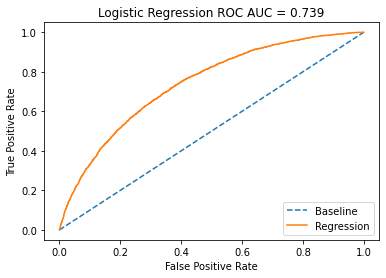

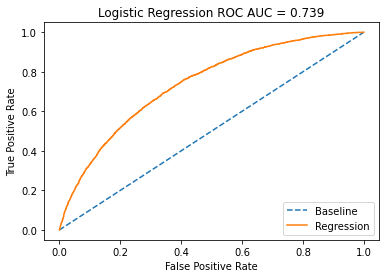

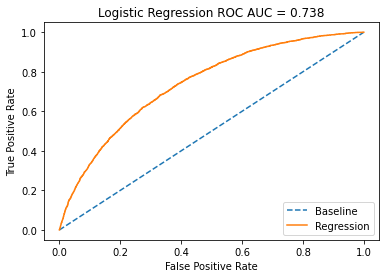

(None, None, None)

In [58]:
def show_ROC_AUC(lgr):    
    probs = lgr.predict_proba(X_test)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
show_ROC_AUC(lgr0), show_ROC_AUC(lgr1), show_ROC_AUC(lgr2)

Кривые практически не отличаются

### Метрики

In [59]:
def show_metrics(y_pred,name = ''):
    print('Метрики для модели ', name)
    print('accuracy: {:.3f}'.format(accuracy_score(y_test,y_pred)))
    print('precision: {:.3f}'.format(precision_score(y_test,y_pred)))
    print('recall: {:.3f}'.format(recall_score(y_test,y_pred)))
    print('f1 score: {:.3f}'.format(f1_score(y_test,y_pred)))

for i in range(3):
    show_metrics(y_pred[:,i],i)
    

Метрики для модели  0
accuracy: 0.874
precision: 0.451
recall: 0.023
f1 score: 0.044
Метрики для модели  1
accuracy: 0.874
precision: 0.451
recall: 0.023
f1 score: 0.044
Метрики для модели  2
accuracy: 0.666
precision: 0.226
recall: 0.686
f1 score: 0.340


Модель lgr2 имеет несколько худшую точность, зато намного лучший f1 score. Разницы же между первыми двумя моделями практически нет.
Учитывая, что основная задача - не точность, а не дать ненадежному клиенту кредит, будем дальше работать с lgr2.

### Матрица ошибок

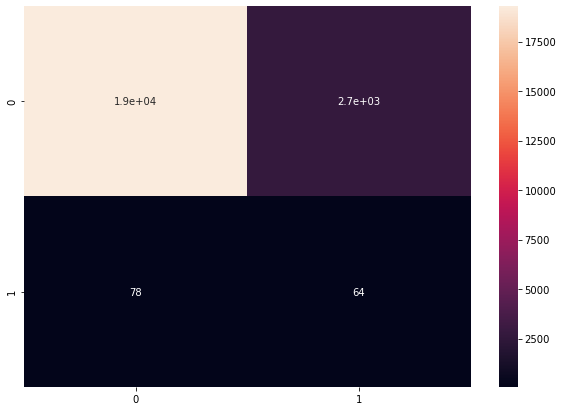

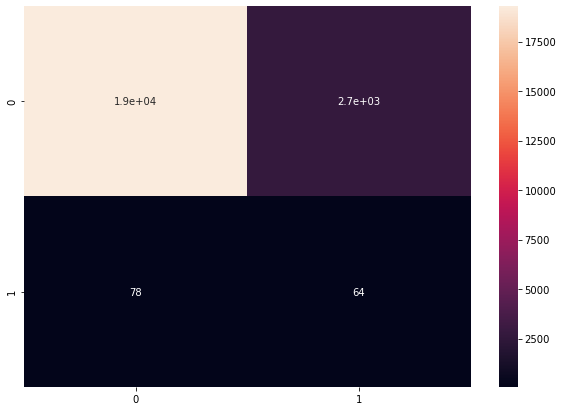

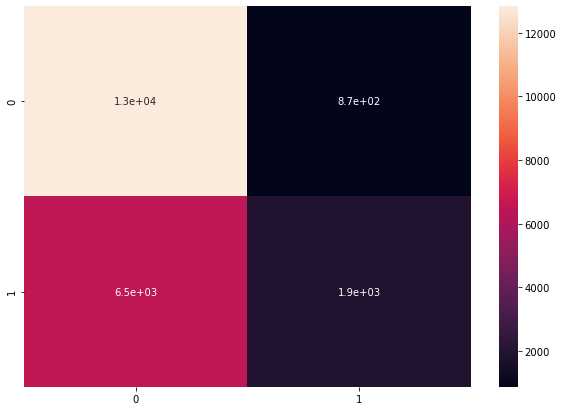

In [60]:
def show_conf_mat(y_pred,name = ''):
    conf_mat = confusion_matrix(y_test, y_pred).T
    df_cm = pd.DataFrame(conf_mat)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
    
for i in range(3):
    show_conf_mat(y_pred[:,i],i)

Несмотря на высокую точность первых двух моделей результаты не радуют - так мы всем раздадим деньги банка и будем искать новую работу..
Поэтому да, lgr2 выглядит здесь намного предпочтительнее.

### Кросс валидация

Для проверки устойчивости модели

In [61]:
cross_val = cross_val_score(lgr2, X_test, y_test, cv=10, scoring='roc_auc')

print('Значения: ',cross_val)
print('Среднее: {:.4f}'.format(cross_val.mean()))
print('Отклонение: {:.4f}'.format(cross_val.std()))

Значения:  [0.75228908 0.72931655 0.72792861 0.73489989 0.75096617 0.74140853
 0.74467492 0.728146   0.73834837 0.71895438]
Среднее: 0.7367
Отклонение: 0.0103


### Оценка вклада признаков в модели

Вот непонятно зачем пример увел нас от dataset, сейчас X_train это нечитаемая матрица..

X = np.hstack([x_num, train[bin_cols].values, x_cat])

In [62]:
print(lgr2.coef_)

[[ 0.00000000e+00  1.37005210e-01  5.24502533e-01  4.90500376e-01
   5.18235678e-01 -2.54001441e-01  0.00000000e+00  3.32168313e-01
   0.00000000e+00  0.00000000e+00 -1.82662755e-01 -1.01368360e+00
   3.15274409e-01  2.70009275e-01  1.66297669e-01 -1.00269891e-01
   1.35432425e-01 -4.99020913e-01 -2.58572435e-01 -8.93551190e-01
   4.20628987e-01  2.78569776e-01 -3.52194603e-03 -2.71643598e-01
  -1.89770579e-01 -2.27178143e-01 -1.15712302e+00 -3.33032001e-02
  -3.26024896e-01  3.79427060e-01  2.13600152e-01 -6.44156318e-02
   4.51717399e-01  0.00000000e+00 -2.82054486e-01 -1.34261114e-05
   1.36585917e-01 -3.09638836e-01  0.00000000e+00 -6.71093094e-02
   1.65693398e-01  0.00000000e+00  9.12959569e-02 -1.05867308e-01
  -2.63671142e-01 -2.74362123e-01 -6.66601623e-02  0.00000000e+00
   9.30258960e-02  1.36865390e-01 -5.07324711e-01 -1.26389635e-01
   0.00000000e+00  1.35430577e-01]]


Я понимаю конечно, что надо бы написать это все кодом.. И удалить лишние признаки.
В общем, в следующий раз лучше объединяться в команду) Не стал удалять

## Интереса ради

Просто интересно, если сократить выборку до сбалансированной, может она будет лучше предсказывать?

In [63]:
train1 = train.drop(['client_id','app_date'], axis=1)

In [64]:
# Преобразуем бинарные и категории
label_encoder = LabelEncoder()

for column in bin_cols:
    train1[column] = label_encoder.fit_transform(train1[column])
    
train1=pd.get_dummies(train1, prefix=cat_cols, columns=cat_cols)

In [65]:
# Разбиваем выборку на дефолтных клиентов и нет
train1_def = train1[train1['default'] == 1]
train1_ok = train1[train1['default'] == 0]

# Объединяем обе выборки, оставим количество недефолтных клиентов примерно равным дефолтному 
train1_bal = train1_def.merge(train1_ok[:10000], how = 'outer')

# Разбиение
y1 = train1_bal['default']
X1 = train1_bal.drop(['default'], axis=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=RANDOM_SEED)

# Нормализация
scaler = StandardScaler()
num_cols1 = ['age', 'score_bki', 'region_rating', 'income']

scaler.fit(X1_train[num_cols1])
X1_train_norm = scaler.transform(X1_train[num_cols1])
scaler.fit(X1_test[num_cols1])
X1_test_norm = scaler.transform(X1_test[num_cols1])

# Модель
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X1_train_norm, y1_train)
y1_pred = model.predict(X1_test_norm)

print('accuracy: {:.3f}'.format(accuracy_score(y1_test,y1_pred)))
print('precision: {:.3f}'.format(precision_score(y1_test,y1_pred)))
print('recall: {:.3f}'.format(recall_score(y1_test,y1_pred)))
print('f1 score: {:.3f}'.format(f1_score(y1_test,y1_pred)))

accuracy: 0.621
precision: 0.618
recall: 0.584
f1 score: 0.601


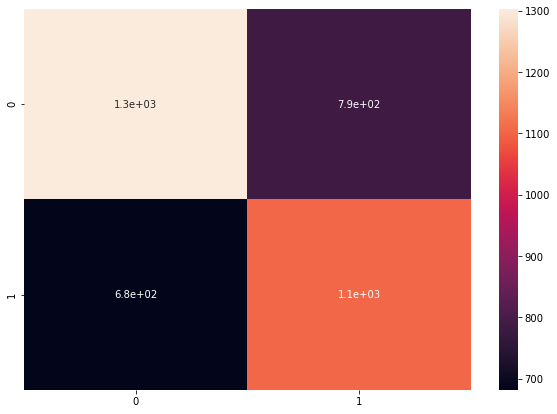

In [66]:
conf_mat1 = confusion_matrix(y1_test, y1_pred).T
df_cm1 = pd.DataFrame(conf_mat1)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm1, annot=True)

Хоть она и нашла существенно меньше правильных ответов, чем наша итоговая модель, но все же первая ее итерация была намного успешнее. Возможно, нужно было идти по этому пути

## Submission

In [67]:
lgr = LogisticRegression(random_state=RANDOM_SEED, C=1, class_weight= 'balanced', dual= False, fit_intercept= True,
                         intercept_scaling= 1, l1_ratio= None, multi_class= 'auto', n_jobs= None, penalty= 'l1',
                         solver = 'liblinear', verbose= 0, warm_start= False)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]


my_submission = pd.DataFrame({'client_id': id_test, 'default': probs})

my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.215491
1,17527,0.800330
2,75683,0.327532
3,26883,0.368907
4,28862,0.137369
...,...,...
36344,83775,0.803422
36345,106254,0.103949
36346,81852,0.799155
36347,1971,0.655298
